# Lista 1: Machine Learning
Por: Isabella Nascimento

## Exercício 1:

Utilizando o notebook "linear-regularized.ipynb", disponível no repositório do curso conseguimos em aula uma acurácia em torno de 8-9% para previsão de preços de imóveis. Usando apenas os modelos vistos até aqui - isto é, Regressão Linear, Ridge e Elastic Net - o seu desafio será aumentar a acurácia dos modelos, conforme medido pelo medida "MAPE" (Mean Absolute Percentage Error).

Para isso, você deverá trabalhar no pré-tratamento de dados, construir novas features e eventualmente eliminar algumas variáveis explicativas de seu dataset original No notebook desenvolvido, pede-se que você:

• Justifique todas as escolhas para tratamento de outliers e missing values. Você tentou mais de uma abordagem? Houve impactos relevantes nos resultados?

• Você selecionou um subconjunto de features para treinar os modelos? Qual foi o impacto? Qual foi o critério utilizado para essa seleção de variáveis?

• Você construiu novas features a partir do dataset original? Em caso positivo, justifique suas construções, e avalie se as novas variáveis se mostraram relevantes.

 ### Resolução:
 # DATA 
    1. Carregar pacotes:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import skew
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
  
import plotly.express as px

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7.5]
import matplotlib


    2. Carregar e analisar base de dados:

In [2]:
#Upload de base de dados: 
df = pd.read_csv('/Users/isabellanascimento/Documents/FGV -RI/Lista1/house-prices-advanced-regression-techniques/train.csv')

In [3]:
#Divisão entre train e test:
train, test = train_test_split(df, test_size=0.3, random_state=7)
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [4]:
#Dropando Id da base de train e test:
train = train.drop(['Id'], axis=1)
test = test.drop(['Id'], axis=1)

In [5]:
#Visualização do início das bases:
train.head(5)
test.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
606,20,RL,82.0,12464,Pave,NaN,IR2,Low,AllPub,Corner,...,0,NaN,GdPrv,NaN,0,11,2009,WD,Normal,152000
1210,60,RL,70.0,11218,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,400,5,2010,WD,Normal,189000
492,60,RL,105.0,15578,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2006,New,Partial,172785
410,20,RL,68.0,9571,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,COD,Abnorml,60000
396,20,RL,60.0,7200,Pave,NaN,Reg,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2009,WD,Normal,123000


In [6]:
#Reordenando as colunas para começarem com "Sale Price"

#Na base de treino:
cols_to_order = ['SalePrice']
new_columns = cols_to_order + (train.columns.drop(cols_to_order).tolist())
train = train[new_columns]
train.head()

#Na base de teste:
cols_to_order = ['SalePrice']
new_columns = cols_to_order + (test.columns.drop(cols_to_order).tolist())
test = test[new_columns]
test.head()

,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
606,152000,20,RL,82.0,12464,Pave,NaN,IR2,Low,AllPub,...,0,0,NaN,GdPrv,NaN,0,11,2009,WD,Normal
1210,189000,60,RL,70.0,11218,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,400,5,2010,WD,Normal
492,172785,60,RL,105.0,15578,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2006,New,Partial
410,60000,20,RL,68.0,9571,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2009,COD,Abnorml
396,123000,20,RL,60.0,7200,Pave,NaN,Reg,Low,AllPub,...,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal


In [7]:
train.columns
test.columns

Index(['SalePrice', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'Pav

In [8]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1022 entries, 680 to 175
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SalePrice      1022 non-null   int64  
 1   MSSubClass     1022 non-null   int64  
 2   MSZoning       1022 non-null   object 
 3   LotFrontage    834 non-null    float64
 4   LotArea        1022 non-null   int64  
 5   Street         1022 non-null   object 
 6   Alley          68 non-null     object 
 7   LotShape       1022 non-null   object 
 8   LandContour    1022 non-null   object 
 9   Utilities      1022 non-null   object 
 10  LotConfig      1022 non-null   object 
 11  LandSlope      1022 non-null   object 
 12  Neighborhood   1022 non-null   object 
 13  Condition1     1022 non-null   object 
 14  Condition2     1022 non-null   object 
 15  BldgType       1022 non-null   object 
 16  HouseStyle     1022 non-null   object 
 17  OverallQual    1022 non-null   int64  
 18  Overall

In [9]:
train.describe()
test.describe()

,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,438.000000,438.000000,367.000000,438.000000,438.000000,438.000000,438.000000,438.000000,436.000000,438.000000,...,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000
mean,183952.954338,59.303653,67.596730,10736.625571,6.205479,5.563927,1972.815068,1986.317352,98.371560,446.363014,...,484.739726,102.369863,42.687215,22.020548,3.235160,16.226027,4.061644,87.465753,6.374429,2007.826484
std,85374.332525,45.649711,20.510181,13409.229282,1.352603,1.086331,29.923473,20.375361,190.924862,455.868385,...,219.897887,130.105661,55.764587,62.025071,30.913949,58.881734,49.075651,869.124717,2.749077,1.348627
min,55000.000000,20.000000,21.000000,1300.000000,3.000000,2.000000,1880.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,129000.000000,20.000000,57.000000,7500.000000,5.000000,5.000000,1955.000000,1969.000000,0.000000,0.000000,...,336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,165750.000000,50.000000,67.000000,9419.500000,6.000000,5.000000,1976.000000,1995.000000,0.000000,379.000000,...,480.000000,44.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,216500.000000,73.750000,80.000000,11441.000000,7.000000,6.000000,2002.000000,2004.000000,135.250000,710.250000,...,594.750000,169.500000,63.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,755000.000000,190.000000,160.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2096.000000,...,1390.000000,857.000000,288.000000,301.000000,508.000000,410.000000,648.000000,15500.000000,12.000000,2010.000000


# Missing Values

Sobre os missing values, um caminho seria preencher os NAs com a média:

all_data = all_data.fillna(all_data.mean())

No entanto, vamos tentar outra coisa para aumentar a precisão

In [10]:
#missing data: ver lista dos maiores percentuais de missing data para ambas as bases

#Para a base de treino:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1018,99.608611
MiscFeature,987,96.575342
Alley,954,93.346380
Fence,825,80.724070
FireplaceQu,471,46.086106
LotFrontage,188,18.395303
GarageType,60,5.870841
GarageYrBlt,60,5.870841
GarageQual,60,5.870841
GarageCond,60,5.870841


In [11]:
#Para a base de teste:
total = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/test.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,435,99.315068
MiscFeature,419,95.662100
Alley,415,94.748858
Fence,354,80.821918
FireplaceQu,219,50.000000
LotFrontage,71,16.210046
GarageType,21,4.794521
GarageYrBlt,21,4.794521
GarageQual,21,4.794521
GarageCond,21,4.794521


In [12]:
#vamos dropar tudo com mais de 45% de missing data:
train2 = train.drop((missing_data[missing_data['Percent'] > 45]).index,1)

/var/folders/qx/ht85q3s909xfbx_mfsf77j040000gn/T/ipykernel_5342/2062584677.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train2 = train.drop((missing_data[missing_data['Percent'] > 45]).index,1)


In [13]:
test2 = test.drop((missing_data[missing_data['Percent'] > 45]).index,1)

/var/folders/qx/ht85q3s909xfbx_mfsf77j040000gn/T/ipykernel_5342/2505121663.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test2 = test.drop((missing_data[missing_data['Percent'] > 45]).index,1)


In [14]:
#Checando se deu certo:

#Para treino:
total = train2.isnull().sum().sort_values(ascending=False)
percent = (train2.isnull().sum()/train2.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
#resultado: deu :)

,Total,Percent
LotFrontage,188,18.395303
GarageType,60,5.870841
GarageYrBlt,60,5.870841
GarageFinish,60,5.870841
GarageQual,60,5.870841
GarageCond,60,5.870841
BsmtFinType2,31,3.033268
BsmtFinType1,30,2.935421
BsmtQual,30,2.935421
BsmtCond,30,2.935421


In [15]:
#Para teste:
total = test2.isnull().sum().sort_values(ascending=False)
percent = (test2.isnull().sum()/test2.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
#resultado: deu :)

,Total,Percent
LotFrontage,71,16.210046
GarageType,21,4.794521
GarageYrBlt,21,4.794521
GarageFinish,21,4.794521
GarageQual,21,4.794521
GarageCond,21,4.794521
BsmtExposure,8,1.826484
BsmtQual,7,1.598174
BsmtFinType2,7,1.598174
BsmtCond,7,1.598174


In [16]:
#como "LotFrontage" tem apenas 18% de missing values em treino e 16% em teste, 
#vou substituir o que falta pela média:
train2['LotFrontage'].fillna(value = train.LotFrontage.mean(), inplace = True)
train2['LotFrontage'].isnull().sum()

0

In [17]:
test2['LotFrontage'].fillna(value = test.LotFrontage.mean(), inplace = True)
test2['LotFrontage'].isnull().sum()

0

In [18]:
#Vou seguir a mesma logica para as demais variaveis inteiras:
train2 = train2.fillna(train.mean())
test2 = test2.fillna(test.mean())

/var/folders/qx/ht85q3s909xfbx_mfsf77j040000gn/T/ipykernel_5342/3404966506.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train2 = train2.fillna(train.mean())
/var/folders/qx/ht85q3s909xfbx_mfsf77j040000gn/T/ipykernel_5342/3404966506.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test2 = test2.fillna(test.mean())


In [19]:
#e preencher para as de garagem com "missing":
train2['GarageQual'].fillna('Missing', inplace = True)
train2['GarageType'].fillna('Missing', inplace = True)
train2['GarageFinish'].fillna('Missing', inplace = True)
train2['GarageCond'].fillna('Missing', inplace = True)
test2['GarageQual'].fillna('Missing', inplace = True)
test2['GarageType'].fillna('Missing', inplace = True)
test2['GarageFinish'].fillna('Missing', inplace = True)
test2['GarageCond'].fillna('Missing', inplace = True)

In [20]:
#de resto, vamos dropar
train2 = train2.drop(['BsmtFinType2',
                      'MasVnrArea',
 'GarageYrBlt',
 'BsmtExposure',
 'BsmtCond',
 'BsmtFinType1',
 'BsmtQual',
 'MasVnrType',
 'Electrical'], axis=1)

In [21]:
test2 = test2.drop(['BsmtFinType2',
                      'MasVnrArea',
 'GarageYrBlt',
 'BsmtExposure',
 'BsmtCond',
 'BsmtFinType1',
 'BsmtQual',
 'MasVnrType',
 'Electrical'], axis=1)

In [22]:
#por fim, testamos pra ver se deu certo:
total =train2.isnull().sum().sort_values(ascending=False)
percent = (train2.isnull().sum()/train2.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
SalePrice,0,0.0
GarageFinish,0,0.0
2ndFlrSF,0,0.0
LowQualFinSF,0,0.0
GrLivArea,0,0.0
BsmtFullBath,0,0.0
BsmtHalfBath,0,0.0
FullBath,0,0.0
HalfBath,0,0.0
BedroomAbvGr,0,0.0


In [23]:
total =test2.isnull().sum().sort_values(ascending=False)
percent = (test2.isnull().sum()/test2.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
#resultado: deu certo :)

,Total,Percent
SalePrice,0,0.0
GarageFinish,0,0.0
2ndFlrSF,0,0.0
LowQualFinSF,0,0.0
GrLivArea,0,0.0
BsmtFullBath,0,0.0
BsmtHalfBath,0,0.0
FullBath,0,0.0
HalfBath,0,0.0
BedroomAbvGr,0,0.0


In [24]:
#Checando se temos observações repetidas:
train2.duplicated().sum()

0

# Agora, vamos ver a distribuição da nossa variável de interesse: o preço

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Log(price + 1)'}>]], dtype=object)

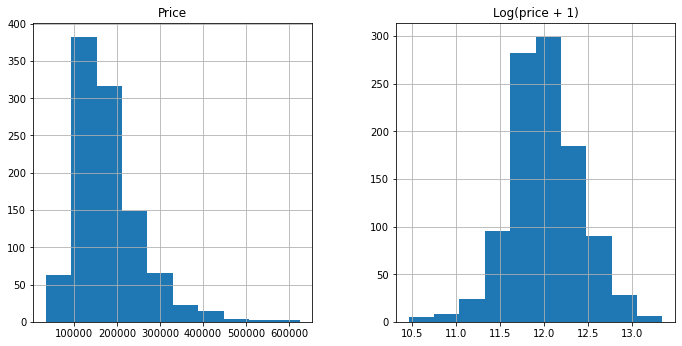

In [25]:
#Ver distribuição de dados de "preço" sem log e com log
#referência: https://leandeep.com/datalab-kaggle/regularized-linear-models.html  

matplotlib.rcParams['figure.figsize'] = (11.5, 5.5)
distrib_price = pd.DataFrame({"Price":train["SalePrice"], "Log(price + 1)":np.log1p(train["SalePrice"])})
distrib_price.hist()
#Concluímos que, ao alterar para o log, melhoramos a distribuição.

In [26]:
#Transofrmacao em log do SalePrice:
train["SalePrice"] = np.log1p(train["SalePrice"])

#transformação de log - skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) 
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

## Encoding

In [27]:
#Variaveis objeto
train2.select_dtypes(include=['object'])

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,CentralAir,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
680,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,...,Y,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1451,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,...,Y,Ex,Typ,Attchd,Fin,TA,TA,Y,New,Partial
1196,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,Y,Gd,Typ,BuiltIn,Fin,TA,TA,Y,New,Partial
1024,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Timber,Norm,Norm,...,Y,Gd,Typ,Attchd,Fin,TA,TA,Y,COD,Abnorml
157,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,Timber,Norm,Norm,...,Y,Ex,Typ,BuiltIn,Fin,TA,TA,Y,New,Partial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Norm,Norm,...,Y,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
502,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Feedr,Norm,...,Y,TA,Typ,Detchd,Unf,Fa,Fa,Y,WD,Normal
537,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,...,Y,TA,Typ,Detchd,Unf,TA,TA,Y,COD,Normal
1220,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,Y,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Abnorml


In [28]:
#Criando matrizes para o sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.SalePrice
y_test = test.SalePrice

In [29]:
#Para facilitar a vida do encoding, vou fazer get all dummies:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Ver fatores que mais impactam o preço:

In [30]:
train2.corr()["SalePrice"].sort_values(key = lambda x: abs(x), ascending=False)

SalePrice        1.000000
OverallQual      0.792616
GrLivArea        0.685925
GarageCars       0.648662
GarageArea       0.633108
TotalBsmtSF      0.593294
1stFlrSF         0.577121
FullBath         0.572412
TotRmsAbvGrd     0.554947
YearBuilt        0.547021
YearRemodAdd     0.528536
Fireplaces       0.443334
BsmtFinSF1       0.355317
WoodDeckSF       0.321522
2ndFlrSF         0.318918
HalfBath         0.311407
OpenPorchSF      0.310761
LotFrontage      0.308479
LotArea          0.265426
BsmtUnfSF        0.238221
BsmtFullBath     0.229005
BedroomAbvGr     0.197328
EnclosedPorch   -0.139244
KitchenAbvGr    -0.130130
ScreenPorch      0.081897
MSSubClass      -0.076050
OverallCond     -0.075161
MoSold           0.066849
3SsnPorch        0.062535
LowQualFinSF    -0.052552
PoolArea         0.044963
BsmtHalfBath    -0.037059
YrSold          -0.018397
MiscVal         -0.015617
BsmtFinSF2       0.007372
Name: SalePrice, dtype: float64

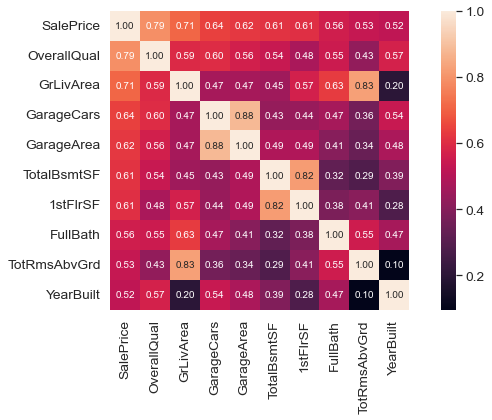

In [31]:
#mais uma forma de olhar: matriz de correlação
#inspirada em https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python
corrmat = train2.corr()
k = 10 
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#aqui temos um mapa de todas as variáveis mais correlacionadas com "SalePrice":
#OverallQual, GrLivArea, GarageCars, GarageArea, FullBath, YearBuilt...


  # 2 Modelos de previsão:

In [32]:
def mape(Y_actual, Y_Predicted):
    mape = round(np.mean(np.abs( Y_actual - Y_Predicted)/Y_actual)*100, 2)
    return mape
def rmse(Y_actual, Y_Predicted):
    rmse = np.mean( (Y_actual - Y_Predicted)**2 /Y_actual )*100
    rmse = round(rmse, 2)
    return rmse  
def mpe(Y_actual, Y_Predicted):
    mpe = np.mean((Y_actual - Y_Predicted)/Y_actual)*100
    mpe = round(mpe, 2)
    return mpe

In [33]:
#modelo naive
naive_model = y_train.mean()
pred_naive = np.repeat(naive_model, len(y_test))
mape( y_test , np.exp(pred_naive))

32.25

In [34]:
#linear regression - scikit learn: apenas com Gr Living Area
linear_reg = LinearRegression()
linear_reg.fit(X_train[['GrLivArea']], y_train)
pred_linear = linear_reg.predict(X_test[['GrLivArea']])

mape( y_test, np.exp(pred_linear))


21.77

In [35]:
#linear regression - scikit learn: adicionando as variáveis que possuem maior 
#correlação com Sales Price -- matriz de correlação

x_list = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'FullBath', 'YearBuilt']

linear_reg = LinearRegression()
linear_reg.fit(X_train[x_list], y_train)
pred_linear = linear_reg.predict(X_test[x_list])

mape( y_test, np.exp(pred_linear))
#Resultado: o MAPE diminuiu, portanto temos um modelo melhor agora.

13.82

# Ridge:

Minha tentativa de fazer o RIDGE utilizando o meu código deu errado e segue aqui:


In [36]:
#ridge_reg = Ridge(alpha = 4) 
#ridge_reg.fit(X_train, y_train)
#ridge_pred = ridge_reg.predict(X_test)

#mape( y_test, np.exp(ridge_pred) )

Tomando em consideração que a minha estimação falhou e inspirada em https://www.kaggle.com/code/apapiu/regularized-linear-models, utilizei parte do código dele para entender como conseguiria uma boa estimação do modelo ridge. Esta segue abaixo com as modificações necessárias no dataset.

In [37]:
#modificações no all data, que provavelmente fizeram o código funcionar melhor:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

In [38]:
#criando uma nova matriz (mais simples) para fazer a estimação dos modelos
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [39]:
#estimação do ridge:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [40]:
model_ridge = Ridge()

In [41]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)

In [42]:
cv_ridge.min()

0.133946866057472

In [43]:
#utilizando o meu codigo antigo junto com as novas modificações:
ridge_reg = Ridge(alpha = 4)
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_test)

mape( y_test, np.exp(ridge_pred) )
# MAPE está consideravelmente melhor que no modelo de regressão linear.

8.64

# Lasso:


In [44]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)
lasso_pred = model_lasso.predict(X_test)
mape( y_test, np.exp(lasso_pred) )

#MAPE está melhor no Lasso que nos outros modelos.

8.13